# PGExplainer on BA-Shapes dataset for 2-layer GCN

In [1]:
import os
import os.path as osp

import torch
from torch_geometric.data import DataLoader
from torch_geometric.data import download_url, extract_zip

from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.models import *
from dig.xgraph.utils.compatibility import compatible_state_dict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Load dataset

In [2]:
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask


def split_dataset(dataset):
    indices = []
    num_classes = 4
    train_percent = 0.7
    for i in range(num_classes):
        index = (dataset.data.y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)

    train_index = torch.cat([i[:int(len(i) * train_percent)] for i in indices], dim=0)

    rest_index = torch.cat([i[int(len(i) * train_percent):] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]

    dataset.data.train_mask = index_to_mask(train_index, size=dataset.data.num_nodes)
    dataset.data.val_mask = index_to_mask(rest_index[:len(rest_index) // 2], size=dataset.data.num_nodes)
    dataset.data.test_mask = index_to_mask(rest_index[len(rest_index) // 2:], size=dataset.data.num_nodes)

    dataset.data, dataset.slices = dataset.collate([dataset.data])

    return dataset


dataset = SynGraphDataset('./datasets', 'BA_shapes')
dataset.data.x = dataset.data.x.to(torch.float32)
dataset.data.x = dataset.data.x[:, :1]
# dataset.data.y = dataset.data.y[:, 2]
dim_node = dataset.num_node_features
dim_edge = dataset.num_edge_features
# num_targets = dataset.num_classes
num_classes = dataset.num_classes

splitted_dataset = split_dataset(dataset)
splitted_dataset.data.mask = splitted_dataset.data.test_mask
splitted_dataset.slices['mask'] = splitted_dataset.slices['train_mask']
dataloader = DataLoader(splitted_dataset, batch_size=1, shuffle=False)

### Load model and checkpoints

In [3]:
def check_checkpoints(root='./'):
    if osp.exists(osp.join(root, 'checkpoints')):
        return
    url = ('https://github.com/divelab/DIG_storage/raw/main/xgraph/checkpoints.zip')
    path = download_url(url, root)
    extract_zip(path, root)
    os.unlink(path)


model = GCN_2l(model_level='node', dim_node=dim_node, dim_hidden=300, num_classes=num_classes)
model.to(device)
check_checkpoints()
ckpt_path = osp.join('checkpoints', 'ba_shapes', 'GCN_2l', '0', 'GCN_2l_best.ckpt')
state_dict = compatible_state_dict(torch.load(ckpt_path, map_location='cpu')['state_dict'])
model.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
from dig.xgraph.method import PGExplainer

explainer = PGExplainer(model, in_channels=900, device=device, explain_graph=False)

explainer.train_explanation_network(splitted_dataset)
torch.save(explainer.state_dict(), 'tmp.pt')
state_dict = torch.load('tmp.pt')
explainer.load_state_dict(state_dict)

100%|██████████| 560/560 [00:00<00:00, 10215.51it/s]
560it [00:15, 36.69it/s]
560it [00:13, 40.76it/s]
560it [00:12, 43.24it/s]
560it [00:17, 31.17it/s]
560it [00:22, 24.45it/s]
560it [00:25, 21.85it/s]
560it [00:24, 23.21it/s]
560it [00:22, 25.10it/s]
560it [00:22, 25.44it/s]
560it [00:21, 25.67it/s]
560it [00:23, 24.13it/s]
560it [00:24, 23.08it/s]
560it [00:23, 23.52it/s]
560it [00:18, 30.19it/s]
560it [00:17, 32.79it/s]
560it [00:16, 34.47it/s]
560it [00:16, 33.35it/s]
560it [00:15, 35.07it/s]
560it [00:16, 34.81it/s]
560it [00:16, 33.43it/s]


Epoch: 0 | Loss: 8.894268180855683
Epoch: 1 | Loss: 8.846726562508515
Epoch: 2 | Loss: 8.56760711020657
Epoch: 3 | Loss: 8.010523775539228
Epoch: 4 | Loss: 7.263117306360177
Epoch: 5 | Loss: 6.238618776787605
Epoch: 6 | Loss: 5.265949377949749
Epoch: 7 | Loss: 4.691092160317514
Epoch: 8 | Loss: 4.530065295419523
Epoch: 9 | Loss: 4.613764908297786
Epoch: 10 | Loss: 4.71995146330446
Epoch: 11 | Loss: 4.820705992249506
Epoch: 12 | Loss: 4.902427153342536
Epoch: 13 | Loss: 4.950923837881003
Epoch: 14 | Loss: 4.986500304724489
Epoch: 15 | Loss: 5.010961620828935
Epoch: 16 | Loss: 5.024333437266094
Epoch: 17 | Loss: 5.03567554785737
Epoch: 18 | Loss: 5.043968493065663
Epoch: 19 | Loss: 5.047438699007034
training time is 387.54s


<All keys matched successfully>

### Visualization

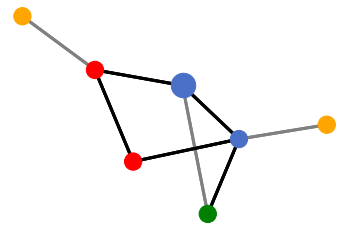

In [5]:
node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
from dig.xgraph.method.pgexplainer import PlotUtils

plotutils = PlotUtils(dataset_name='ba_shapes', is_show=True)
data = dataset[0]
node_idx = node_indices[6]
with torch.no_grad():
    walks, masks, related_preds =
        explainer(data.x, data.edge_index, node_idx=node_idx, y=data.y, top_k=5)

explainer.visualization(data, edge_mask=masks[0], top_k=5, plot_utils=plotutils, node_idx=node_idx)

### Metric results

In [6]:
top_k = 5
undirected_graph = True
# --- Create data collector and explanation processor ---
from dig.xgraph.evaluation import XCollector

x_collector = XCollector()

### Run explainer on the given model and dataset
index = -1
node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
top_k = top_k if not undirected_graph else top_k * 2

for i, data in enumerate(dataloader):
    for j, node_idx in enumerate(node_indices):
        index += 1
        data.to(device)

        if torch.isnan(data.y[0].squeeze()):
            continue

        with torch.no_grad():
            walks, masks, related_preds =
                explainer(data.x, data.edge_index, node_idx=node_idx, y=data.y, top_k=top_k)
            masks = [mask.detach() for mask in masks]
        x_collector.collect_data(masks, related_preds)

        # if you only have the edge masks without related_pred, please feed sparsity controlled mask to
        # obtain the result: x_processor(data, masks, x_collector)
        if index >= 99:
            break

    if index >= 20:
        break

print(f'Fidelity: {x_collector.fidelity:.4f}\n'
      f'Fidelity_inv: {x_collector.fidelity_inv:.4f}\n'
      f'Sparsity: {x_collector.sparsity:.4f}')

Fidelity: 0.8181
Fidelity_inv: 0.7251
Sparsity: 0.2311
